In [1]:
import navis

In [2]:
# Load example neurons
nl = navis.example_neurons()

In [9]:
# Convert neurons into microns (they are 8nm)
nl_um = nl / (1000 / 8)

# Generate dotprops yourself 
dps = navis.make_dotprops(nl_um, k=5, resample=False)
nbl = navis.nblast(dps[:3], dps[3:], progress=False)
nbl

,754534424,754538881
1734350788,0.732750,0.769846
1734350908,0.763332,0.753758
722817260,0.742435,0.794035


In [11]:
# Alternatively:
nbl = navis.nblast(nl_um[:3], nl_um[3:], k=5, progress=False)
nbl

,754534424,754538881
1734350788,0.732750,0.769846
1734350908,0.763332,0.753758
722817260,0.742435,0.794035


In [12]:
aba = navis.nblast_allbyall(dps, progress=False)
aba

,1734350788,1734350908,722817260,754534424,754538881
1734350788,1.000000,0.745212,0.752570,0.732750,0.769846
1734350908,0.734082,1.000000,0.680336,0.763332,0.753758
722817260,0.773668,0.743125,1.000000,0.742435,0.794035
754534424,0.764980,0.767250,0.715229,1.000000,0.784735
754538881,0.760658,0.753321,0.753230,0.762976,1.000000


In [13]:
aba_mean = (aba + aba.T) / 2

In [14]:
aba_dist = (aba_mean - 1) * -1
aba_dist

,1734350788,1734350908,722817260,754534424,754538881
1734350788,-0.000000,0.260353,0.236881,0.251135,0.234748
1734350908,0.260353,-0.000000,0.288269,0.234709,0.246460
722817260,0.236881,0.288269,-0.000000,0.271168,0.226368
754534424,0.251135,0.234709,0.271168,-0.000000,0.226144
754538881,0.234748,0.246460,0.226368,0.226144,-0.000000


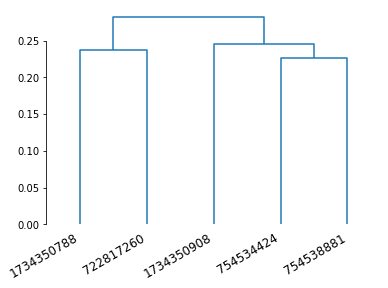

In [15]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette

import matplotlib.pyplot as plt
import matplotlib.colors as mcl
import seaborn as sns

set_link_color_palette([mcl.to_hex(c) for c in sns.color_palette('muted', 10)])

# To generate a linkage, we have to bring the matrix from square-form to vector-form
aba_vec = squareform(aba_dist, checks=False)

# Generate linkage
Z = linkage(aba_vec, method='ward')

# Plot a dendrogram
dn = dendrogram(Z, labels=aba_mean.columns)

ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

sns.despine(trim=True, bottom=True)

In [17]:
# Note that we still want to use data in microns 
# as the scoring function is the same
synbl = navis.synblast(nl_um, nl_um, by_type=True, progress=False)
synbl

,1734350788,1734350908,722817260,754534424,754538881
1734350788,1.000000,0.831690,0.828234,0.820261,0.849559
1734350908,0.831721,1.000000,0.741676,0.857372,0.833785
722817260,0.842672,0.827759,1.000000,0.815891,0.853005
754534424,0.862494,0.853088,0.793840,1.000000,0.866798
754538881,0.845366,0.833463,0.829094,0.844647,1.000000


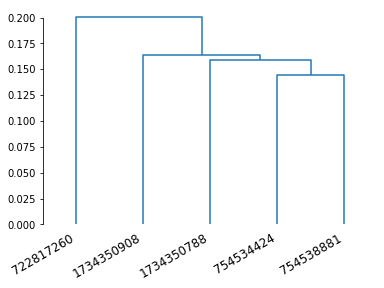

In [18]:
# Generate the linear vector
aba_vec = squareform(((synbl + synbl.T) / 2 - 1) * -1, checks=False)

# Generate linkage
Z = linkage(aba_vec, method='ward')

# Plot a dendrogram
dn = dendrogram(Z, labels=synbl.columns)

ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

sns.despine(trim=True, bottom=True)

In [3]:
import navis.interfaces.neuprint as neu

# Set a client 
client = neu.Client('https://neuprint.janelia.org', dataset='hemibrain:v1.2')

In [6]:
pns = neu.fetch_skeletons(neu.NeuronCriteria(type='.*lPN.*', regex=True), with_synapses=True)
pns.head()

,type,name,id,n_nodes,n_connectors,n_branches,n_leafs,cable_length,soma,units
0,navis.TreeNeuron,VA5_lPN_R,574032862,4509,2849,739,763,3.023454e+05,9,8 nanometer
1,navis.TreeNeuron,VA5_lPN_R,574037281,4365,2891,719,756,2.994139e+05,19,8 nanometer
2,navis.TreeNeuron,VA5_lPN_R,574374051,4480,3000,751,786,3.098901e+05,6,8 nanometer
3,navis.TreeNeuron,DM5_lPN_R,635416407,2589,1443,330,346,1.972500e+05,1507,8 nanometer
4,navis.TreeNeuron,DM1_lPN_R,542634818,16273,15317,3216,3369,1.167167e+06,15873,8 nanometer


In [7]:
pns_um = pns / (1000 / 8)
pns_dps = navis.make_dotprops(pns_um, k=5) 
pns_dps

,type,name,id,k,units,n_points
0,navis.Dotprops,VA5_lPN_R,574032862,5,1.0 micrometer,4509
1,navis.Dotprops,VA5_lPN_R,574037281,5,1.0 micrometer,4365
...,...,...,...,...,...,...
56,navis.Dotprops,DM1_lPN_L,5813061392,5,1.0 micrometer,25676
57,navis.Dotprops,DM2_lPN_L,5813054061,5,1.0 micrometer,10675


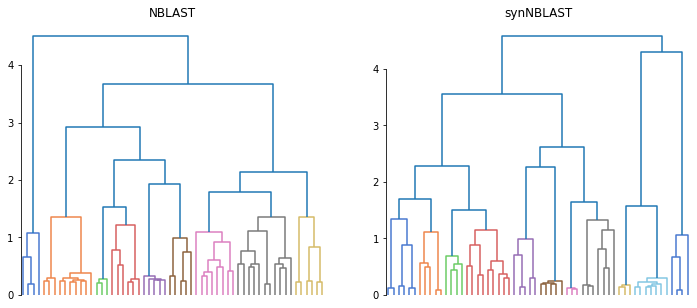

In [19]:
# Run an all-by-all NBLAST and synNBLAST
pns_nbl = navis.nblast_allbyall(pns_dps, progress=False)
pns_synbl = navis.synblast(pns_um, pns_um, by_type=True, progress=False)

# Generate the linear vectors
nbl_vec = squareform(((pns_nbl + pns_nbl.T) / 2 - 1) * -1, checks=False)
synbl_vec = squareform(((pns_synbl + pns_synbl.T) / 2 - 1) * -1, checks=False)

# Generate linkages
Z_nbl = linkage(nbl_vec, method='ward', optimal_ordering=True)
Z_synbl = linkage(synbl_vec, method='ward', optimal_ordering=True)

# Plot dendrograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

dn1 = dendrogram(Z_nbl, no_labels=True, color_threshold=1.5, ax=axes[0])
dn2 = dendrogram(Z_synbl, no_labels=True, color_threshold=1.5, ax=axes[1])

axes[0].set_title('NBLAST')
axes[1].set_title('synNBLAST')

sns.despine(trim=True, bottom=True)

In [37]:
# Generate clusters
from scipy.cluster.hierarchy import fcluster
cl = fcluster(Z_synbl, t=1.5, criterion='distance')
cl

array([ 5,  5,  5,  4,  8,  8,  8,  6,  8, 11,  4,  7, 11, 11,  3,  2,  2,
        4, 10, 10,  3, 10,  6,  1,  2,  2, 11,  7, 11, 11,  7,  7,  7,  2,
        2,  6,  1,  6,  2,  6,  2,  2,  3,  4,  4,  1,  3,  1,  4,  9, 11,
        3,  6,  9,  6,  9,  9,  8], dtype=int32)

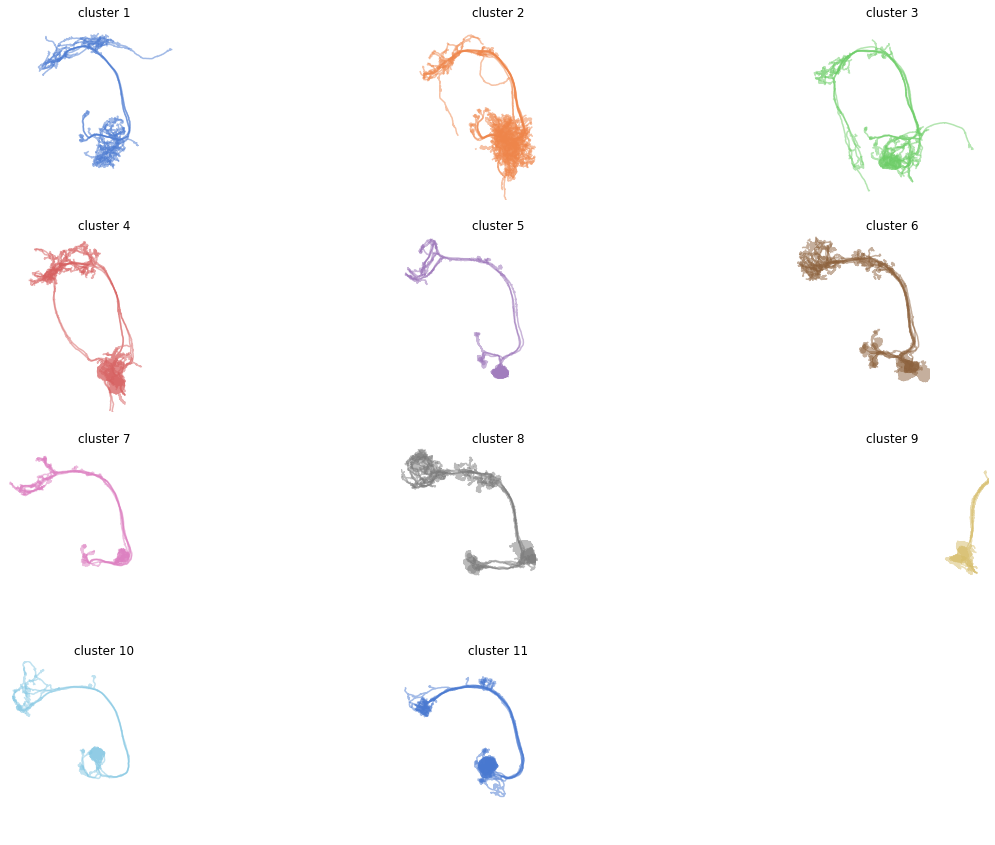

In [69]:
# Now plot each cluster
# For simplicity we are plotting in 2D here 
n_clusters = max(cl)
rows = 4
cols = n_clusters % 4
fig, axes = plt.subplots(rows, cols,
                         figsize=(20, 5 * cols))
# Flatten axes
axes = [ax for l in axes for ax in l]

# Generate colors 
pal = sns.color_palette('muted', n_clusters)

for i in range(n_clusters):
    ax = axes[i]    
    ax.set_title(f'cluster {i + 1}')
    # Get the neurons in this cluster
    this = pns[cl == (i + 1)]
    
    navis.plot2d(this, method='2d', ax=ax, color=pal[i], lw=1.5, view=('x', '-z'), alpha=.5)
    
for ax in axes:    
    ax.set_aspect('equal')
    ax.set_axis_off()
    
    # Set all axes to the same limits
    bbox = pns.bbox
    ax.set_xlim(bbox[0][0], bbox[0][1])
    ax.set_ylim(-bbox[2][1], -bbox[2][0])